## Imports

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Credentials and Authentication

In [2]:
client_credentials_manager = SpotifyClientCredentials(client_id='your-spotify-client-id', client_secret='your-spotify-client-secret')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager,requests_timeout=60)

## Collect Featured Playlists and Information

In [3]:
# Collect top 12 featured playlist IDs
playlist_id = []

featured_playlists = sp.featured_playlists()
for i, f in enumerate(featured_playlists['playlists']['items']):
    playlist_id.append(f['id'])
    if i == 11:
        break


In [4]:
# Gather all tracks in each playlist
album = []
artist = []
track_id = []
track_name = []
track_popularity = []
playlist_name = []
count_errors = 0

for i, p in enumerate(playlist_id):
    playlist_details = sp.playlist(playlist_id=p)
    for j, d in enumerate(playlist_details['tracks']['items']):
        # Check for errors with null values
        try:
            album.append(d['track']['album']['name'])
            artist.append(d['track']['artists'][0]['name'])
            track_id.append(d['track']['id'])
            track_name.append(d['track']['name'])
            track_popularity.append(d['track']['popularity'])
            playlist_name.append(playlist_details['name'])
        except:
            count_errors += 1
print('There were ' + str(count_errors) + ' errors.')

There were 0 errors.


In [5]:
# Gather all track information
danceability = []
energy = []
loudness = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
id = []
duration_ms = []
time_signature = []
count_errors = 0

for i in range(len(track_id)):
    track_features = sp.audio_features(tracks=track_id[i])
    for item in track_features:
        # Check for errors with null values
        try:
            danceability.append(item['danceability'])
            energy.append(item['energy'])
            loudness.append(item['loudness'])
            speechiness.append(item['speechiness'])
            acousticness.append(item['acousticness'])
            instrumentalness.append(item['instrumentalness'])
            liveness.append(item['liveness'])
            valence.append(item['valence'])
            tempo.append(item['tempo'])
            id.append(item['id'])
            duration_ms.append(item['duration_ms'])
            time_signature.append(item['time_signature'])
        except:
            danceability.append(None)
            energy.append(None)
            loudness.append(None)
            speechiness.append(None)
            acousticness.append(None)
            instrumentalness.append(None)
            liveness.append(None)
            valence.append(None)
            tempo.append(None)
            id.append(None)
            duration_ms.append(None)
            time_signature.append(None)
            count_errors += 1
print('There were ' + str(count_errors) + ' errors.')

There were 0 errors.


## Gather All Collected Data in a DataFrame

In [6]:
# Gather all information collected thusfar into a single dataframe
playlist_info = pd.DataFrame({'playlist_name':playlist_name,
    'track_id':track_id,
    'track_name':track_name,
    'track_popularity':track_popularity,
    'danceability':danceability,
    'energy':energy,
    'speechiness':speechiness,
    'acousticness':acousticness,
    'instrumentalness':instrumentalness,
    'liveness':liveness,
    'valence':valence,
    'loudness':loudness,
    'tempo':tempo,
    'duration_ms':duration_ms,
    'time_signature':time_signature,
    'id':id,
    'artist':artist,
    'album':album})

In [7]:
# Adjust datatypes of columns with incorrect datatypes
playlist_info['playlist_name'] = playlist_info['playlist_name'].astype('string')
playlist_info['track_id'] = playlist_info['track_id'].astype('string')
playlist_info['track_name'] = playlist_info['track_name'].astype('string')
playlist_info['id'] = playlist_info['id'].astype('string')
playlist_info['time_signature'] = playlist_info['time_signature'].astype('category')
playlist_info['artist'] = playlist_info['artist'].astype('string')
playlist_info['album'] = playlist_info['album'].astype('string')

# Export dataframe to CSV for future further data analysis
playlist_info.to_csv('playlistTrackStats.csv')

In [8]:
# Gather all track information by playlist and add to its own dataframe
playlist_stats = pd.DataFrame()

for i, c in enumerate(list(playlist_info.columns)):
    if 3 < i < 13:
        playlist_stats = pd.concat([playlist_stats,
            pd.DataFrame(playlist_info.groupby('playlist_name')[c].mean(), columns=[list(playlist_info.columns)[i]])],
            axis=1)
    elif i == 13:
        playlist_stats = pd.concat([playlist_stats,
            pd.DataFrame(playlist_info.groupby('playlist_name')[c].sum(), columns=[list(playlist_info.columns)[i]])],
            axis=1)

In [9]:
# Add a column for a more readable time of each playlist
duration_time = []

for i, ms in enumerate(playlist_stats['duration_ms']):
    sec = ms/1000
    minute = int(sec // 60)
    sec = int(sec - (minute * 60))
    hour = int(minute // 60)
    minute = int(minute - (hour * 60))

    if minute < 10:
        minute = '0' + str(minute)
    if sec < 10:
        sec = '0' + str(sec)

    time_min_sec = str(hour) + ':' + str(minute) + ':' + str(sec)
    duration_time.append(time_min_sec)

playlist_stats['duration_time'] = duration_time

# Export new dataframe to CSV for future further data analysis
playlist_stats.to_csv('playlistStatsCondensed.csv')

## Visualizing the Data

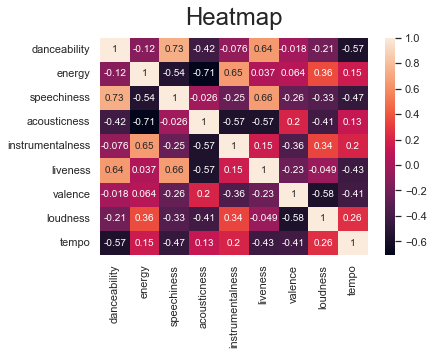

In [10]:
# Heatmap of the correlation coefficients between all the stats
sns.set(rc = {'figure.figsize':(12,10)})
correlations = playlist_stats[playlist_stats.columns[0:9]].corr()
sns.heatmap(correlations, annot=True)
plt.title('Heatmap', y=1.03, fontsize=24)
plt.savefig('images/heatmap.png', facecolor='white')
plt.show()

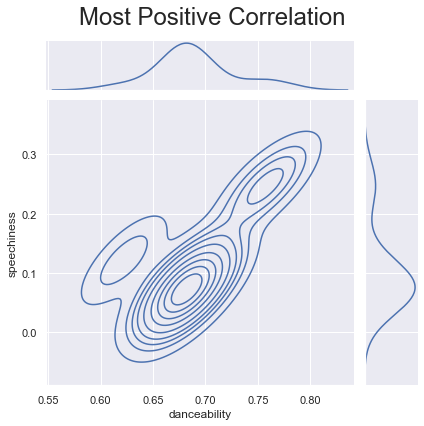

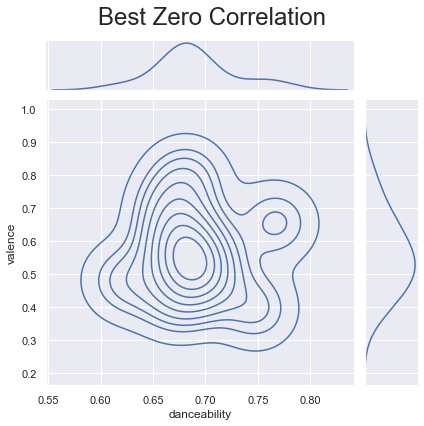

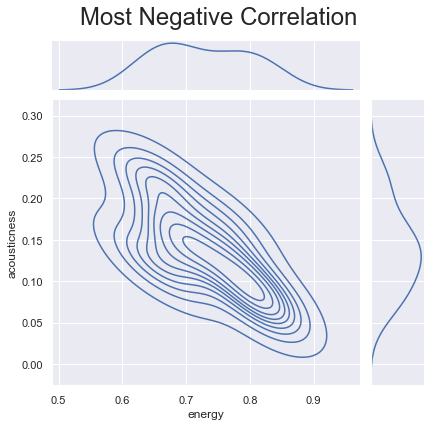

In [11]:
# Setup KDE plot data for the most positive, most negative,
# and closest to zero correlation pairs accross all playlists
neg = 0
pos = 0
zero = 1

correlations = playlist_stats[playlist_stats.columns[0:9]].corr()
for i, cor in enumerate(correlations.index):
    # Most Positive Correlation
    pos_temp = min(correlations[cor].nlargest(2))
    if pos_temp >= pos:
        if pos_temp > pos:
            pos = pos_temp
            pos_col = cor
        else:
            pos_row = cor
    
    # Most Negative Correlation
    neg_temp = min(correlations[cor])
    if neg_temp <= neg:
        if neg_temp < neg:
            neg = neg_temp
            neg_col = cor
        else:
            neg_row = cor
    
    # Zero Correlation
    zero_temp = min(abs(correlations[cor]))
    if zero_temp <= zero:
        if zero_temp < zero:
            zero = zero_temp
            zero_col = cor
        else:
            zero_row = cor

# Plot the info from the setups above
mpc = sns.jointplot(data=playlist_stats, x=pos_col, y=pos_row, kind='kde')
mpc.fig.subplots_adjust(top=.9)
mpc.fig.suptitle('Most Positive Correlation', fontsize=24)
plt.savefig('images/mostPositiveCorrelation.png', facecolor='white')
plt.show()

bzc = sns.jointplot(data=playlist_stats, x=zero_col, y=zero_row, kind='kde')
bzc.fig.subplots_adjust(top=.9)
bzc.fig.suptitle('Best Zero Correlation', fontsize=24)
plt.savefig('images/bestZeroCorrelation.png', facecolor='white')
plt.show()

mnc = sns.jointplot(data=playlist_stats, x=neg_col, y=neg_row, kind='kde')
mnc.fig.subplots_adjust(top=.9)
mnc.fig.suptitle('Most Negative Correlation', fontsize=24)
plt.savefig('images/mostNegativeCorrelation.png', facecolor='white')
plt.show()

In [12]:
# Make polar scatterplots of the data by playlist
fig = make_subplots(rows=4, cols=3, specs=[[{'type':'polar'}]*3]*4, subplot_titles=playlist_stats.index)

for i, name in enumerate(playlist_stats.index):
    fig.add_traces(go.Scatterpolar(name=playlist_stats.index[i],
        r=playlist_stats.iloc[i][0:7],
        theta=playlist_stats.columns), i // 3 + 1, i % 3 + 1)

fig.update_traces(fill='toself')
fig.update_polars(radialaxis_angle=90, radialaxis_tick0=0.2, radialaxis_dtick=0.2, radialaxis_range=[0,1])
for i, name in enumerate(playlist_stats.index):
    fig.update_annotations(x=(25 * (i % 3) + 10) / 70,
        y=(28 * (i // 3) + 17) / 100,
        selector={'text':name})
fig.update_layout(showlegend=False, height=1500, width=1100, title_text='Playlist Polar Plots', title_x=0.5, title_font_size=24)
fig.show()
fig.write_image('images/playlistPolarPlots.png')